<a href="https://colab.research.google.com/github/RamSakamuri/Python_60Days/blob/main/Coefficient_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

In [3]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [4]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


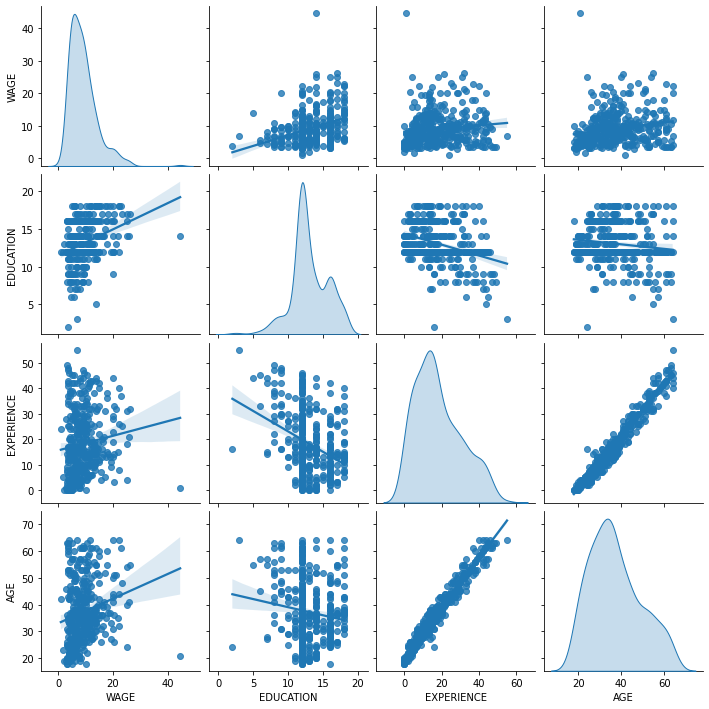

In [6]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [7]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [9]:
_ = model.fit(X_train, y_train)


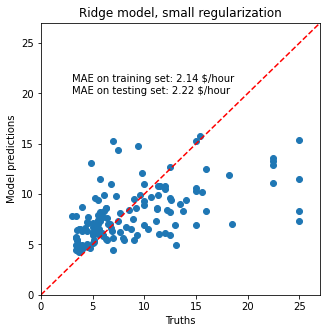

In [10]:
from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_train)

mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} $/hour"
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} $/hour"
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title("Ridge model, small regularization")
plt.ylabel("Model predictions")
plt.xlabel("Truths")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

In [11]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs


,Coefficients
RACE_Hispanic,-0.013555
RACE_Other,-0.009111
RACE_White,0.022558
OCCUPATION_Clerical,0.000056
OCCUPATION_Management,0.090539
OCCUPATION_Other,-0.025091
OCCUPATION_Professional,0.071975
OCCUPATION_Sales,-0.046625
OCCUPATION_Service,-0.091042
SECTOR_Construction,-0.000177


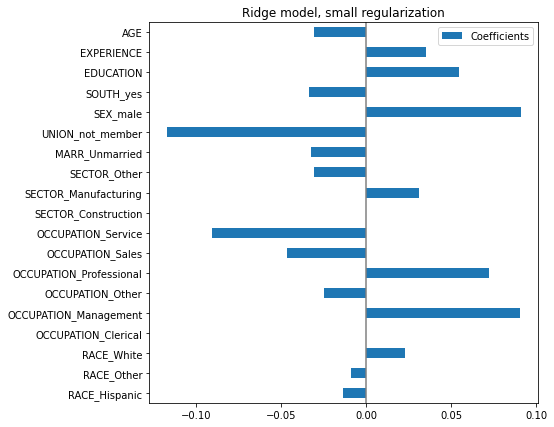

In [12]:
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

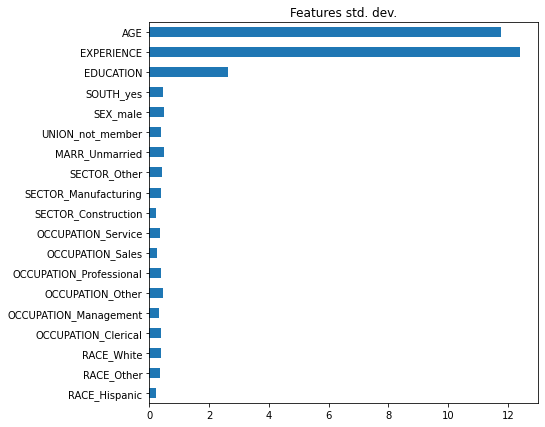

In [13]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps["columntransformer"].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot(kind="barh", figsize=(9, 7))
plt.title("Features std. dev.")
plt.subplots_adjust(left=0.3)

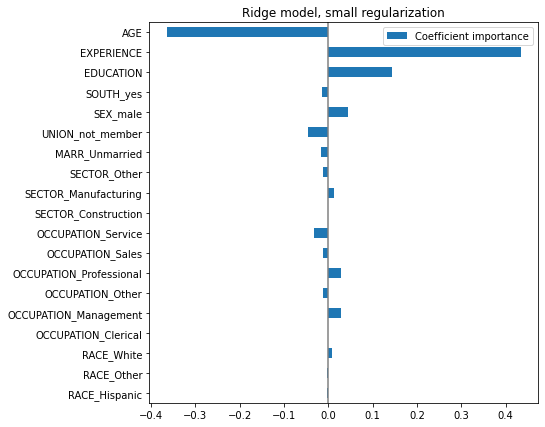

In [14]:
coefs = pd.DataFrame(
    model.named_steps["transformedtargetregressor"].regressor_.coef_
    * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

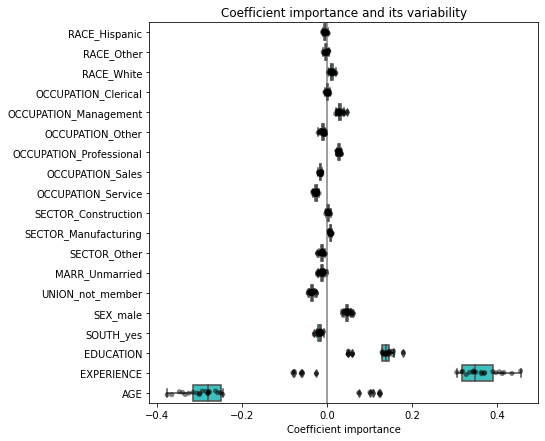

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        * X_train_preprocessed.std(axis=0)
        for est in cv_model["estimator"]
    ],
    columns=feature_names,
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

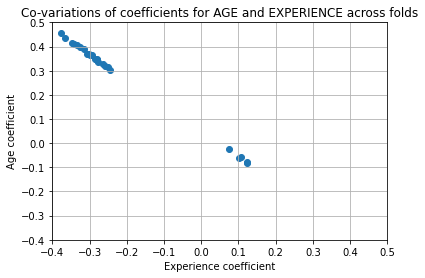

In [16]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

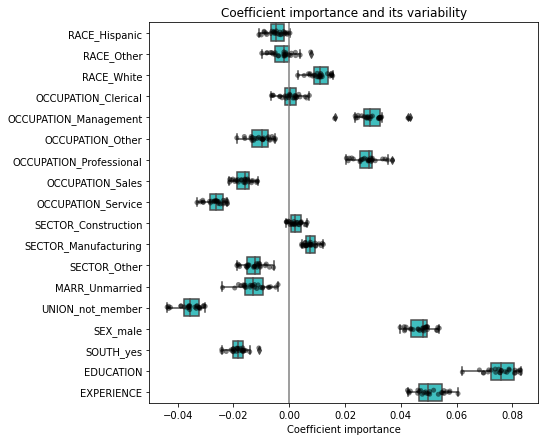

In [17]:
column_to_drop = ["AGE"]

cv_model = cross_validate(
    model,
    X.drop(columns=column_to_drop),
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [
        est.named_steps["transformedtargetregressor"].regressor_.coef_
        * X_train_preprocessed.drop(columns=column_to_drop).std(axis=0)
        for est in cv_model["estimator"]
    ],
    columns=feature_names[:-1],
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)